In [1]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import re
import string
from string import digits

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt
import os

In [2]:
lines = pd.read_csv("/kaggle/input/hindi-english-truncated-corpus/Hindi_English_Truncated_Corpus.csv")
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [3]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [4]:
lines=lines[lines['source']=='ted']

In [5]:
lines.drop_duplicates(inplace=True)

In [6]:
lines=lines.sample(n=25000, random_state=101)
lines.shape

(25000, 3)

# Data Preprocessing

In [7]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [8]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [9]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [10]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [11]:
# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [12]:

lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("[a-zA-Z]", " ", x))

In [13]:
lines.head()

,source,english_sentence,hindi_sentence
67855,ted,that bjorn rorslett from norway sent me,जो मुझे नार्वे से ब्जोर्न रोर्सलेट ने भेजी है
46310,ted,so weve got a much more mainstream appearance ...,इसलिए हम विश्व की मुख्यधारा की सम्भावना के बार...
65949,ted,which is the biggest issue in aircraft design,जोकि विमान डिजाइन में सबसे बड़ा मुद्दा है
1115,ted,and so my blog was just one of those,और मेरा ब्लॉग भी उन में से एक था
90500,ted,peter parker is in a library in manhattan,पीटर पार्कर मैनहैटन की लाइब्रेरी में है


In [14]:
stop_words = stopwords.words('english') 

In [15]:
corpus = ' '
for line in lines['english_sentence']:
    corpus += ' '.join(line.split())
corpus

' that bjorn rorslett from norway sent meso weve got a much more mainstream appearance of the worldwhich is the biggest issue in aircraft designand so my blog was just one of thosepeter parker is in a library in manhattanand when you ask people about connectionits not virginitynow there he is calling to his friendsbut if i say in spite of my body being limitedthey have to go through their primary one thats already awkwardhow do we know that its wrong maybe you and i disagreeyears old and shes solarelectrified houses for me in afghanistanand what youre going to see isone buttock playingin all the ways i just shared with youare ufos alien spaceships or perceptual cognitive mistakes or even fakesbut whose streets we cant walkthis is just another one of the modulesstripped a vehicle of its windshield wipersand if you remember one thing from what i want to talk about todayive met a young man in new york whose illiterate motherbecause we want these puzzles to be difficulti said “no i want to

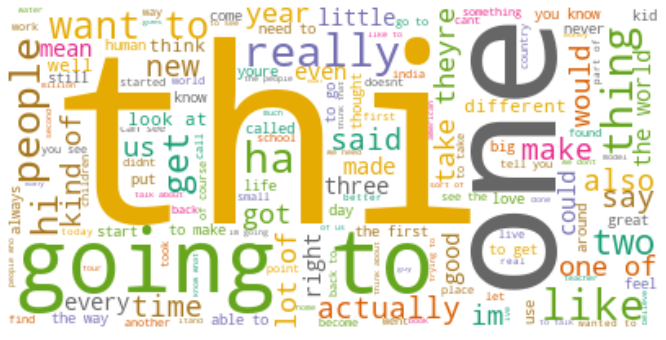

In [16]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150 )

wc.generate(corpus)

plt.rcParams["figure.figsize"] = (16,6)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
    
plt.show()


In [17]:
# Vectorize the data

input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

In [18]:
for line in lines['english_sentence']:
    input_texts.append(line)
    for char in line:
        if re.findall("[a-zA-Z]", char) or char == ' ':
            if char not in input_characters:
                input_characters.add(char)
            
for line in lines['hindi_sentence']:
    
    target_text = '%' + line + '$'
    
    target_texts.append(line)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [19]:
target_characters

{' ',
 '$',
 '%',
 '¼',
 '½',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ऍ',
 'ऎ',
 'ए',
 'ऐ',
 'ऑ',
 'ऒ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'ळ',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'ॄ',
 'ॅ',
 'ॆ',
 'े',
 'ै',
 'ॉ',
 'ॊ',
 'ो',
 'ौ',
 '्',
 'ॐ',
 '॓',
 '।',
 '॰',
 '\u200b',
 '\u200c',
 '‘',
 '“',
 '”',
 '…',
 '™',
 '♫'}

In [20]:
# for line in lines['english_sentence']:
#     for word in line.split():
#         if word not in input_characters:
#             input_characters.add(word)
        
# for line in lines['hindi_sentence']:
#     for word in line.split():
#         if word not in target_characters:
#             target_characters.add(word)

In [21]:
# from nltk import ngrams 
# list(ngrams(words,2))

In [22]:
#input_characters

In [23]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [24]:
print("Number of samples : ", len(input_texts))
print("Number of unique input tokens : ", num_encoder_tokens)
print("Number of unique output tokens : ", num_decoder_tokens)
print("Max sequence length for inputs : ", max_encoder_seq_length)
print("Max sequence length for outputs : ", max_decoder_seq_length)

Number of samples :  25000
Number of unique input tokens :  27
Number of unique output tokens :  86
Max sequence length for inputs :  104
Max sequence length for outputs :  132


In [25]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [26]:
#input_token_index

# Encoder and Decoder Architecture

In [27]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [28]:
print("Encoder input data : ", encoder_input_data.shape)
print("Decoder input data : ", decoder_input_data.shape)
print("Decoder target data : ", decoder_target_data.shape)

Encoder input data :  (25000, 104, 27)
Decoder input data :  (25000, 132, 86)
Decoder target data :  (25000, 132, 86)


# Coverting text into one hot encoding 

In [29]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        if re.findall("[a-zA-Z]", char) or char == ' ': 
            encoder_input_data[i,t, input_token_index[char]] = 1
    encoder_input_data[i,t+1:, input_token_index[' ']] = 1
    
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        
        if t > 0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1
            
    decoder_input_data[i,t+1:, target_token_index[' ']] = 1
    decoder_target_data[i, t:, target_token_index[' ']] = 1

In [30]:
encoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
batch_size = 128 # Batch size for training
epochs = 50 # Number of epochs to train for
latent_dim = 256

# Encoder LSTM model

In [32]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Decoder LSTM Model

In [33]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [34]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 27)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 86)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 290816      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  351232      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [36]:
checkpoint_path = "/kaggle/working/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [37]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
         callbacks=[cp_callback])

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.7675
Epoch 00001: saving model to /kaggle/working/training_1/cp.ckpt
157/157 [==============================] - 198s 1s/step - loss: 1.1237 - accuracy: 0.7675 - val_loss: 0.9182 - val_accuracy: 0.7726
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.7890
Epoch 00002: saving model to /kaggle/working/training_1/cp.ckpt
157/157 [==============================] - 195s 1s/step - loss: 0.8264 - accuracy: 0.7890 - val_loss: 0.7620 - val_accuracy: 0.7997
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.8114
Epoch 00003: saving model to /kaggle/working/training_1/cp.ckpt
157/157 [==============================] - 197s 1s/step - loss: 0.7037 - accuracy: 0.8114 - val_loss: 0.6767 - val_accuracy: 0.8183
Epoch 4/50
157/157 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8254
Epoch 00004: saving model to

In [38]:
# # Loads the weights
# model.load_weights('/kaggle/working/training_1/cp.ckpt')

In [39]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['%']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    
    stop_condition = False
    
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        
        if (sampled_char == '$' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [41]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence : ', input_texts[seq_index])
    print('Decoded sentence : ', decoded_sentence)

-
Input sentence :  that bjorn rorslett from norway sent me
Decoded sentence :   के समस्या ये है कि यह सब                                                                                                            
-
Input sentence :  so weve got a much more mainstream appearance of the world
Decoded sentence :   के समय से ये सब कुछ साल के बारे में बात करते हैं                                                                                    
-
Input sentence :  which is the biggest issue in aircraft design
Decoded sentence :   के समस्या ये है कि यह एक बार हम प्रकाश के लिए                                                                                       
-
Input sentence :  and so my blog was just one of those
Decoded sentence :  हाँ हम में से कुछ काम करते हैं                                                                                                       
-
Input sentence :  peter parker is in a library in manhattan
Decoded sentence :   के साथ काम करने के लिए कि हम क्या कर सक

**References**

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html